In [6]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from kerastuner.tuners import RandomSearch
import scipy.io as sio

<ipython-input-7-9e369164ead7>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Trial 10 Complete [00h 02m 00s]
val_loss: 0.029406389221549034

Best val_loss So Far: 0.029406389221549034
Total elapsed time: 00h 14m 48s
Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3201 - val_loss: 0.0310
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1907 - val_loss: 0.0372
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1866 - val_loss: 0.0370
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1866 - val_loss: 0.0361
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1881 - val_loss: 0.0348
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1866 - val_loss: 0.0336
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1850 - val_loss: 0.0325
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1867 - val_loss: 0.0315
Epoch 9/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1860 - val_loss: 0.0308
Epoch 10/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1855 - val_los

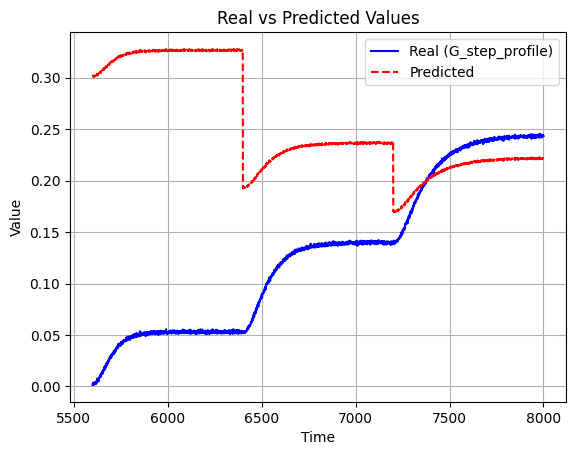

The best number of units is: 150
The best learning rate is: 0.00022221143188447883


In [8]:
mat_file = sio.loadmat('result_stepchange.mat')

# Extract the necessary fields
G_step_profile = mat_file['G_step_profile'].flatten()  # Assuming 1D array
U = mat_file['U'].flatten()
Time_profile = mat_file['Time_profile'].flatten()

# Combine input U and output G_step_profile
X = np.column_stack((U, G_step_profile))

# Normalize
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# train-validation split
split_ratio = 0.7
train_size = int(len(X_scaled) * split_ratio)

X_train = X_scaled[:train_size]
X_val = X_scaled[train_size:]

# Reshape data
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# function to build the LSTM model with hyperparameters
def build_model(hp):
    model = Sequential()

    # number of units in the LSTM layer
    units = hp.Int('units', min_value=50, max_value=200, step=50)
    model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

    # learning rate for the optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    return model

# Initiate the tuner with RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='lstm_tune')

# Perform the hyperparameter search
tuner.search(X_train, X_train, epochs=100, validation_data=(X_val, X_val), batch_size=32)

# optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

#best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, X_train, epochs=100, validation_data=(X_val, X_val), batch_size=32)

#predictions on validation data
y_pred = best_model.predict(X_val)

# Plot real vs predicted values
plt.figure()
plt.plot(Time_profile[train_size:], X_val[:, 0, 1], 'b', label='Real (G_step_profile)')
plt.plot(Time_profile[train_size:], y_pred[:, 0], 'r--', label='Predicted')
plt.title('Real vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Print the best hyperparameters
print(f"The best number of units is: {best_hps.get('units')}")
print(f"The best learning rate is: {best_hps.get('learning_rate')}")
